# Exploratory Data Analysis on AB_NYC_2019 dataset

### PLEASE NOTE: 

### This notebook contains only the code that is required for the charts, tables, and visualisations presented in the Airbnb business analysis report. The complete EDA and thought process can be found in the full notebook.

## Import Libraries

In [65]:
%pip install kmodes

Note: you may need to restart the kernel to use updated packages.


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import scipy.stats as st
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
# ignore future deprecation
warnings.filterwarnings('ignore')

Read the AB_NYC_2019.csv file

In [67]:
airbnb = pd.read_csv("AB_NYC_2019.csv")

There are a lot of missing variables, especially last_review and reviews_per_month.

Replace null values with appropriate values:
- name is categorical so will simply be replaced with "Replaced name"
- host_name is categorical so will simply be replaced with "Replaced host name"
- last_review is date so will be replaced with 0 (0 is not ideal for dates but we won't be using this variable, null value is replaced to avoid any errors)
- review_per_month is a continuous variable so will be replaced with 0

In [68]:
airbnb['name'].fillna('Replaced name', inplace=True)
airbnb['host_name'].fillna('Replaced host name', inplace=True)
airbnb['last_review'].fillna(0, inplace=True)
airbnb['reviews_per_month'].fillna(0, inplace=True)

In [69]:
airbnb.drop(airbnb[airbnb.price == 0].index, inplace=True)
airbnb.drop(airbnb[airbnb.availability_365 == 0].index, inplace=True)

Log transform `price` to normalise the distribution

In [70]:
airbnb['log_price'] = np.log(airbnb['price'])

Price is the charge per night which isn't a particularly helpful figure for Airbnb on its own.

We will therefore calculate the total revenue opportuity to Airbnb for each room if it were to be booked for every day that it is available. This is of course unlikely, but it is a useful comparrison as to the potential maximum revenue of each room. The commission for each room is 17% of the price charged, made-up of 3% host fee and 14% guest fee: https://www.airbnb.co.uk/resources/hosting-homes/a/how-much-does-airbnb-charge-hosts-288

Revenue_opportunity = price * availability_365 * 0.17

In [71]:
airbnb['revenue_opportunity'] = airbnb['price'] * airbnb['availability_365'] * 0.17

Also log transform `revenue_opportunity`

In [72]:
airbnb['log_revenue_opportunity'] = np.log(airbnb['revenue_opportunity'])

### Figure 1. Revenue opportunity

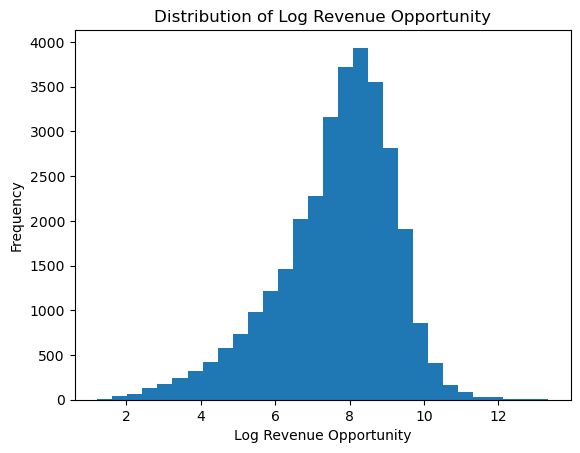

In [73]:
plt.hist(airbnb['log_revenue_opportunity'], bins=30)
plt.xlabel('Log Revenue Opportunity')
plt.ylabel('Frequency')
plt.title('Distribution of Log Revenue Opportunity')
plt.show()

Text(0, 0.5, 'Revenue opportunity @ 17% commission')

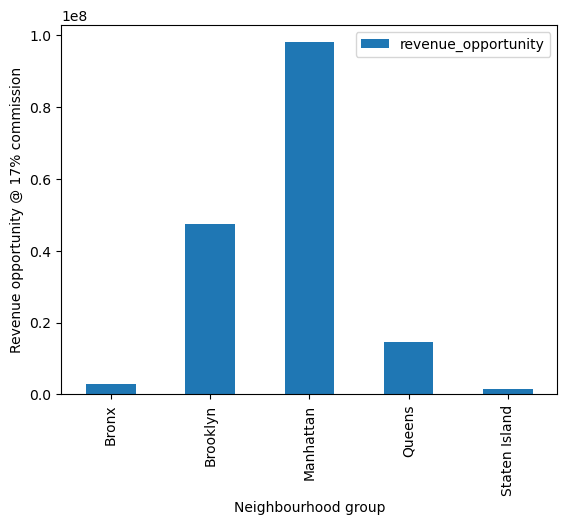

In [74]:
neighbourhood_group = airbnb.pivot_table(index ='neighbourhood_group',values = 'revenue_opportunity', aggfunc = np.sum)
neighbourhood_group.plot(kind = 'bar')
plt.xlabel('Neighbourhood group')
plt.ylabel('Revenue opportunity @ 17% commission')

### Figure 2. Proportion of listings per resident

In [75]:
# Create new dataframe, .reset_index() to convert series into dataframe
counts_df = airbnb.neighbourhood_group.value_counts().reset_index()
counts_df.columns = ['Neighbourhood Group', 'Listings']

# Create population dict from cencus data
population_dict = {
    'Manhattan': 1.629e6,
    'Brooklyn': 2.577e6,
    'Queens': 2.271e6,
    'Bronx': 1.476e6,
    'Staten Island': 476e3
}

# Add population column to df
counts_df['Population'] = counts_df['Neighbourhood Group'].map(population_dict).apply(lambda x: int(x))

# Add listings per resident to df
counts_df['Listings per Resident'] = (counts_df['Listings'] / counts_df['Population']).round(5)

counts_df

,Neighbourhood Group,Listings,Population,Listings per Resident
0,Manhattan,13559,1629000,0.00832
1,Brooklyn,12253,2577000,0.00475
2,Queens,4298,2271000,0.00189
3,Bronx,913,1476000,0.00062
4,Staten Island,331,476000,0.00070


In [76]:
styled_df = counts_df.style.background_gradient(
    cmap='Blues'
).hide_index().format(
    {
        "Listings": "{:,.0f}", 
        "Population": "{:,.0f}",
        "Listings per Resident": "{:.5g}"
    }
).set_table_styles(
    [
        {
            'selector': 'th',
            'props': [
                ('padding', '1px'),
                ('text-align', 'left')
            ]
        },
        {
            'selector': 'td',
            'props': [
                ('padding', '1px'),
                ('text-align', 'center')
            ]
        }
    ]
).set_properties(**{'width': '70px'})

styled_df

Neighbourhood Group,Listings,Population,Listings per Resident
Manhattan,"13,559","1,629,000",0.00832
Brooklyn,"12,253","2,577,000",0.00475
Queens,"4,298","2,271,000",0.00189
Bronx,913,"1,476,000",0.00062
Staten Island,331,"476,000",0.0007


### Figure 3. Potential revenue increase if all groups have the same ratio as Manhattan

In [77]:
mean_revenue_dict = airbnb.groupby('neighbourhood_group')['revenue_opportunity'].mean().to_dict()
mean_revenue_dict

revenue_opportunity_dict = airbnb.pivot_table(index='neighbourhood_group', values='revenue_opportunity', aggfunc=np.sum).to_dict()['revenue_opportunity']
revenue_opportunity_dict

{'Bronx': 2872252.1700000004,
 'Brooklyn': 47567733.830000006,
 'Manhattan': 97984186.9,
 'Queens': 14702861.91,
 'Staten Island': 1541384.73}

In [78]:
table_2 = pd.DataFrame()

# Build columns
table_2['Neighbourhood Group'] = counts_df['Neighbourhood Group']
table_2['Listings * 0.00832'] = counts_df['Population'] * 0.00832
table_2['Mean Revenue'] = table_2['Neighbourhood Group'].map(mean_revenue_dict)
table_2['Current Revenue Opportunity'] = table_2['Neighbourhood Group'].map(revenue_opportunity_dict)
table_2['Potential Revenue * 0.00832'] = table_2['Mean Revenue'] * table_2['Listings * 0.00832']

# Hardcode Manhattan back since that is the baseline and rounding changes the value
table_2.loc[table_2['Neighbourhood Group'] == 'Manhattan', 'Potential Revenue * 0.00832'] = 97984186.9

table_2['Potential Revenue Increase'] = table_2['Potential Revenue * 0.00832'] - table_2['Current Revenue Opportunity']

table_2

,Neighbourhood Group,Listings * 0.00832,Mean Revenue,Current Revenue Opportunity,Potential Revenue * 0.00832,Potential Revenue Increase
0,Manhattan,13553.28,7226.505413,97984186.90,9.798419e+07,0.000000e+00
1,Brooklyn,21440.64,3882.129587,47567733.83,8.323534e+07,3.566761e+07
2,Queens,18894.72,3420.861310,14702861.91,6.463622e+07,4.993335e+07
3,Bronx,12280.32,3145.949803,2872252.17,3.863327e+07,3.576102e+07
4,Staten Island,3960.32,4656.751450,1541384.73,1.844223e+07,1.690084e+07


In [79]:
# Currency format func
def format_currency_in_millions(value):
    return "$ {:.1f}M".format(value / 1_000_000)

# format
styled_table_2 = table_2.style.format({
    'Listings * 0.00832': "{:,.0f}",
    'Mean Revenue': "$ {:,.0f}",
    'Current Revenue Opportunity': format_currency_in_millions,
    'Potential Revenue * 0.00832': format_currency_in_millions,
    'Potential Revenue Increase': format_currency_in_millions
}).background_gradient(cmap='Blues', subset=['Listings * 0.00832', 'Mean Revenue', 'Current Revenue Opportunity', 'Potential Revenue * 0.00832', 'Potential Revenue Increase']).hide_index().set_table_styles([
   {
      'selector': 'th',
      'props': [
          ('padding', '1px'),
          ('text-align', 'left')
      ]
   }, 
   {
      'selector': 'td',
      'props': [('padding', '1px'),
        ('text-align', 'center')]
   },
]).set_properties(**{'width': '60px'})

styled_table_2


Neighbourhood Group,Listings * 0.00832,Mean Revenue,Current Revenue Opportunity,Potential Revenue * 0.00832,Potential Revenue Increase
Manhattan,"13,553","$ 7,227",$ 98.0M,$ 98.0M,$ 0.0M
Brooklyn,"21,441","$ 3,882",$ 47.6M,$ 83.2M,$ 35.7M
Queens,"18,895","$ 3,421",$ 14.7M,$ 64.6M,$ 49.9M
Bronx,"12,280","$ 3,146",$ 2.9M,$ 38.6M,$ 35.8M
Staten Island,"3,960","$ 4,657",$ 1.5M,$ 18.4M,$ 16.9M


### Figure 4. DBSCAN Clustering

In [80]:
# keeping less than we're dropping so just picking those features
cluster_data = airbnb[['price', 'log_price', 'neighbourhood_group', 'latitude', 'longitude', 'room_type', 'revenue_opportunity', 'log_revenue_opportunity', 'availability_365']]
cluster_data

# Create a copy of the data 
cluster_data_prepared = cluster_data.copy()

# Encode categorical variables
le = LabelEncoder()
cluster_data_prepared['room_type_xform'] = le.fit_transform(cluster_data['room_type'])
cluster_data_prepared['neighbourhood_group_xform'] = le.fit_transform(cluster_data['neighbourhood_group'])

In [81]:
dbscan=DBSCAN(eps=0.9,min_samples=9)
dbscan.fit(cluster_data_prepared[['log_revenue_opportunity','room_type_xform','neighbourhood_group_xform']])

DBSCAN(eps=0.9, min_samples=9)

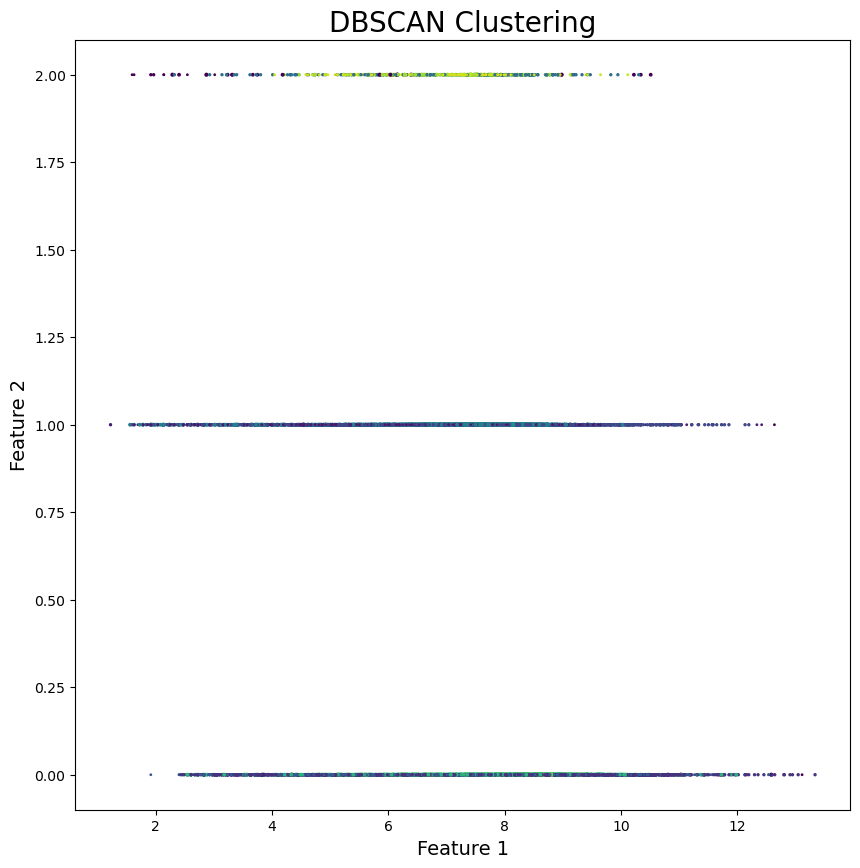

In [82]:
cluster_data_prepared['DBSCAN_labels']=dbscan.labels_ 
plt.figure(figsize=(10,10))
plt.scatter(cluster_data_prepared['log_revenue_opportunity'],cluster_data_prepared['room_type_xform'],cluster_data_prepared['neighbourhood_group_xform'],c=cluster_data_prepared['DBSCAN_labels'])
plt.title('DBSCAN Clustering',fontsize=20)
plt.xlabel('Feature 1',fontsize=14)
plt.ylabel('Feature 2',fontsize=14)
plt.show()

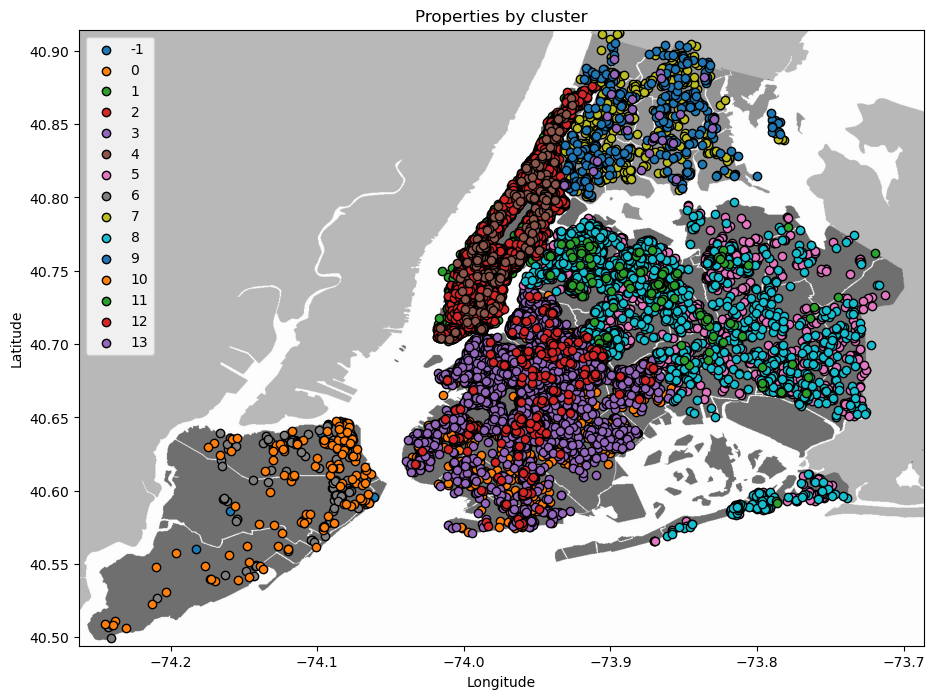

In [83]:
plt.figure(figsize=(12,8))
plt.style.use('fast')
# Set the boundary of the map using longitude and latitude obtained from Google Maps
coordinates = (-74.2623, -73.6862, 40.4943, 40.9144)
map = mpimg.imread("New_York_City.jpg")
plt.imshow(map,extent=coordinates)
groups = cluster_data_prepared.groupby('DBSCAN_labels')
for name,group in groups :
     plt.scatter(group['longitude'],group['latitude'], label=name, edgecolors='black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Properties by cluster')
plt.legend()

plot queens here since this is used for the LR in figure 6

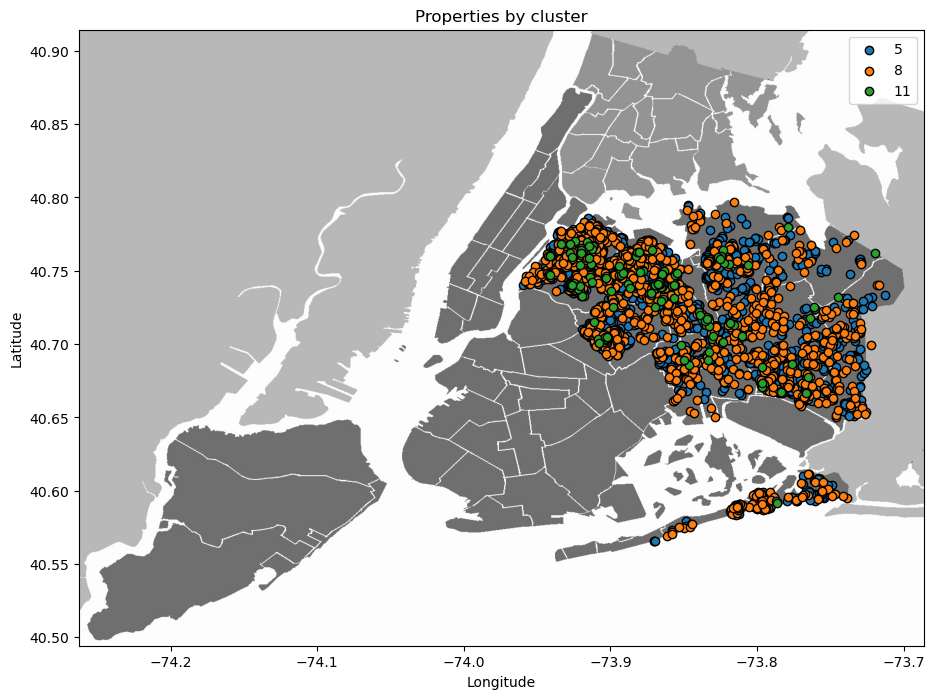

In [84]:
plt.figure(figsize=(12,8))
plt.style.use('fast')
# Set the boundary of the map using longitude and latitude obtained from Google Maps
coordinates = (-74.2623, -73.6862, 40.4943, 40.9144)
map = mpimg.imread("New_York_City.jpg")
plt.imshow(map,extent=coordinates)
Queens = cluster_data_prepared[(cluster_data_prepared['DBSCAN_labels'] == 5) | (cluster_data_prepared['DBSCAN_labels'] == 8) | (cluster_data_prepared['DBSCAN_labels'] == 11)]
groups = Queens.groupby('DBSCAN_labels')
for name,group in groups :
     plt.scatter(group['longitude'],group['latitude'], label=name, edgecolors='black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Properties by cluster')
plt.legend()

### Figure 5. Revenue opportunity distribution per cluster

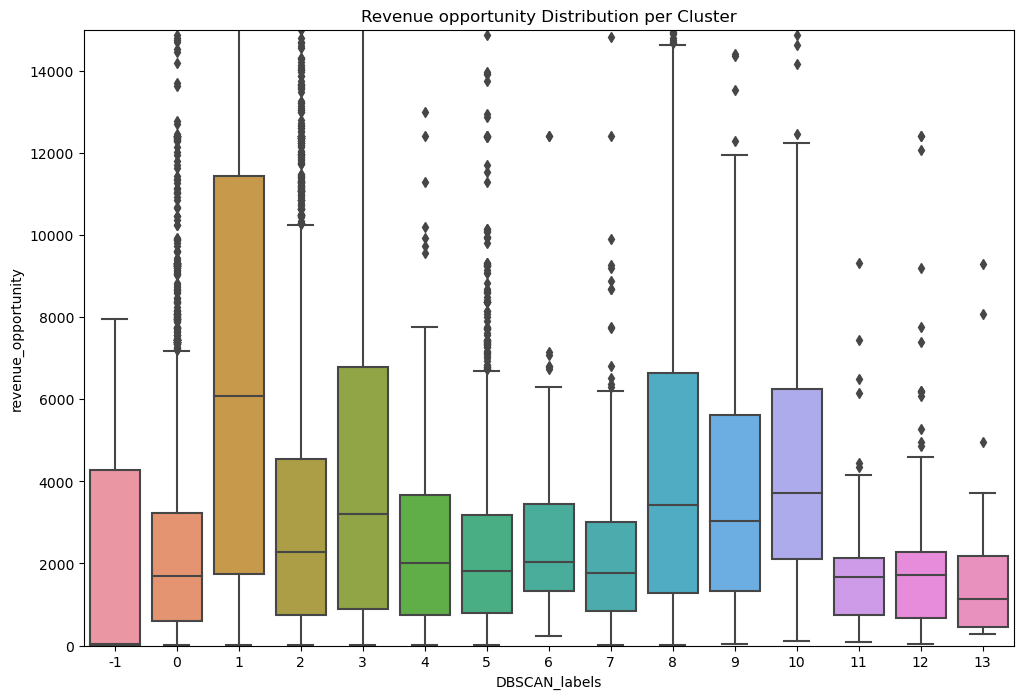

In [85]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='DBSCAN_labels', y='revenue_opportunity', data=cluster_data_prepared)
plt.title('Revenue opportunity Distribution per Cluster')
plt.axis(ymin=0, ymax=15000)
plt.show()

### Figure 6. Linear Regression

In [86]:
msk=np.random.rand(len(Queens))<0.8
train=Queens[msk]
test=Queens[~msk]

Using sklearn package for data modelling

longitude

In [87]:
regr=linear_model.LinearRegression()
train_x=np.asanyarray(train[['longitude']])
train_y=np.asanyarray(train[['log_revenue_opportunity']])

regr.fit(train_x, train_y)
# The coefficients
print('Coefficients:', regr.coef_)
print('Intercept:', regr.intercept_)

Coefficients: [[1.84684823]]
Intercept: [143.86871794]


Text(0, 0.5, 'Log revenue opportunity')

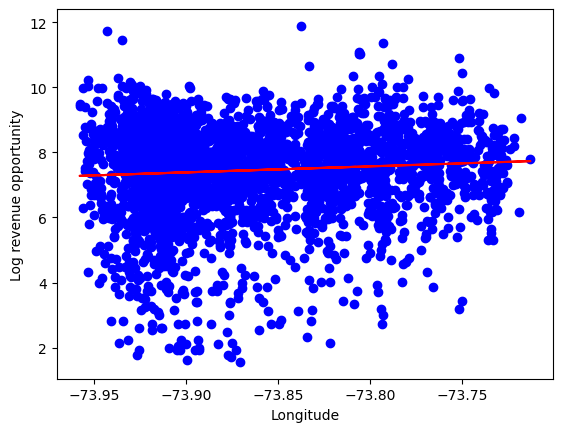

In [88]:
# Plot outputs
plt.scatter(train.longitude,train.log_revenue_opportunity,color='blue')
plt.plot(train_x,regr.coef_[0][0]*train_x + regr.intercept_[0],'-r')
plt.xlabel("Longitude")
plt.ylabel("Log revenue opportunity")

latitude

In [89]:
regr=linear_model.LinearRegression()
train_x=np.asanyarray(train[['latitude']])
train_y=np.asanyarray(train[['log_revenue_opportunity']])

regr.fit(train_x, train_y)
# The coefficients
print('Coefficients:', regr.coef_)
print('Intercept:', regr.intercept_)

Coefficients: [[-3.08822326]]
Intercept: [133.22685362]


Text(0, 0.5, 'Log revenue opportunity')

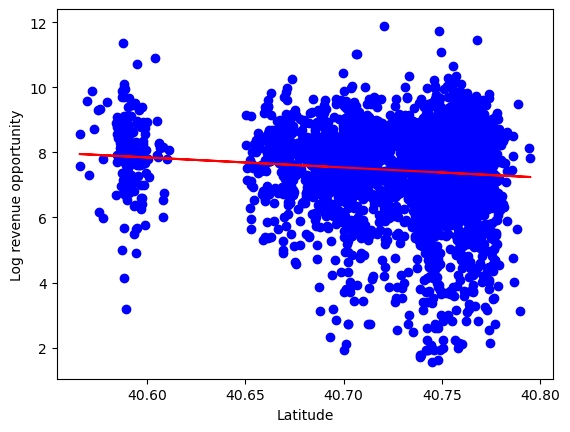

In [90]:
# Plot outputs
plt.scatter(train.latitude,train.log_revenue_opportunity,color='blue')
plt.plot(train_x,regr.coef_[0][0]*train_x + regr.intercept_[0],'-r')
plt.xlabel("Latitude")
plt.ylabel("Log revenue opportunity")

### Figure 7. K-means silhouette and elbow

In [91]:
# create reduced dataframe
kmeans_run = Queens[['log_revenue_opportunity']]
kmeans_run

,log_revenue_opportunity
46,8.466216
77,8.257282
143,3.169686
161,7.433773
181,9.985874
...,...
48858,8.339195
48863,5.399700
48866,7.357390
48878,7.182200


Standardise (not really required with one variable, but still normalising for consistency)

In [92]:
# standardise numeric variables
scaler = StandardScaler()
kmeans_run[['log_revenue_opportunity']] = scaler.fit_transform(kmeans_run[['log_revenue_opportunity']])

Silhouette score for k (clusters) = 2 is 0.5893624681654775
Silhouette score for k (clusters) = 3 is 0.530886924845948
Silhouette score for k (clusters) = 4 is 0.5254176792839207
Silhouette score for k (clusters) = 5 is 0.5194508357370409
Silhouette score for k (clusters) = 6 is 0.523834365832839
Silhouette score for k (clusters) = 7 is 0.5218336849536875
Silhouette score for k (clusters) = 8 is 0.5247260216642161
Silhouette score for k (clusters) = 9 is 0.5235383488660361
Silhouette score for k (clusters) = 10 is 0.5270604910271481
Silhouette score for k (clusters) = 11 is 0.5278831498609623
Silhouette score for k (clusters) = 12 is 0.5300666182194343


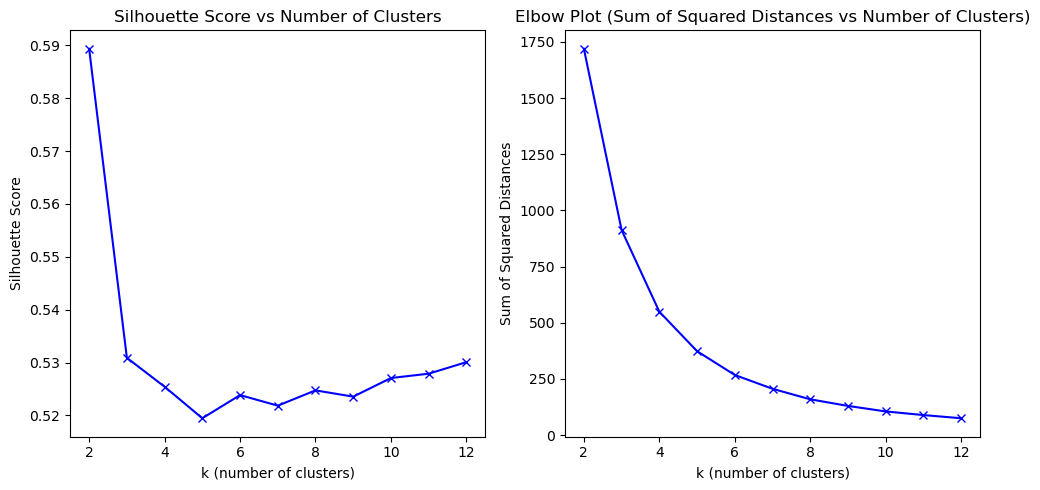

In [93]:
k_values = []
sil_scores = []
sq_distances = []

for i in range(2,13):
    # Initialize KMeans algorithm
    # 12 times per run to find the optimal centroids
    # random_state to ensure the same clusters every time we run this
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=12, random_state=0)

    # Fit and predict clusters
    clusters = kmeans.fit_predict(kmeans_run) 

    # Compute silhouette score
    SScore = silhouette_score(kmeans_run, clusters, metric='euclidean')

    # Append to the lists
    k_values.append(i)
    sil_scores.append(SScore)
    sq_distances.append(kmeans.inertia_)  # Sum of squared distances to closest centroid

    print("Silhouette score for k (clusters) = " + str(i) + " is " + str(SScore))

# Plot silhouette scores
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(k_values, sil_scores, 'bx-')
plt.xlabel('k (number of clusters)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')

# Plot sum of squared distances (for the elbow plot)
plt.subplot(1, 2, 2)
plt.plot(k_values, sq_distances, 'bx-')
plt.xlabel('k (number of clusters)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Plot (Sum of Squared Distances vs Number of Clusters)')

plt.tight_layout()
plt.show()

In [94]:
# Initialize KMeans algorithm
# 12 times per run to find the optimal centroids
# random_state to ensure the same clusters every time we run this
kmeans_optimal = KMeans(n_clusters=4, init='k-means++', n_init=12, random_state=0)

# Fit and predict clusters
clusters_optimal = kmeans_optimal.fit_predict(kmeans_run) 

In [95]:
kmeans_run['cluster'] = clusters_optimal
kmeans_run

,log_revenue_opportunity,cluster
46,0.753796,3
77,0.600156,0
143,-3.141014,2
161,-0.005412,0
181,1.871278,3
...,...,...
48858,0.660391,3
48863,-1.501170,1
48866,-0.061580,0
48878,-0.190406,0


Place original lat & long back so the results can be plotted on the map


In [96]:
kmeans_run['latitude'] = Queens[['latitude']]
kmeans_run['longitude'] = Queens[['longitude']]

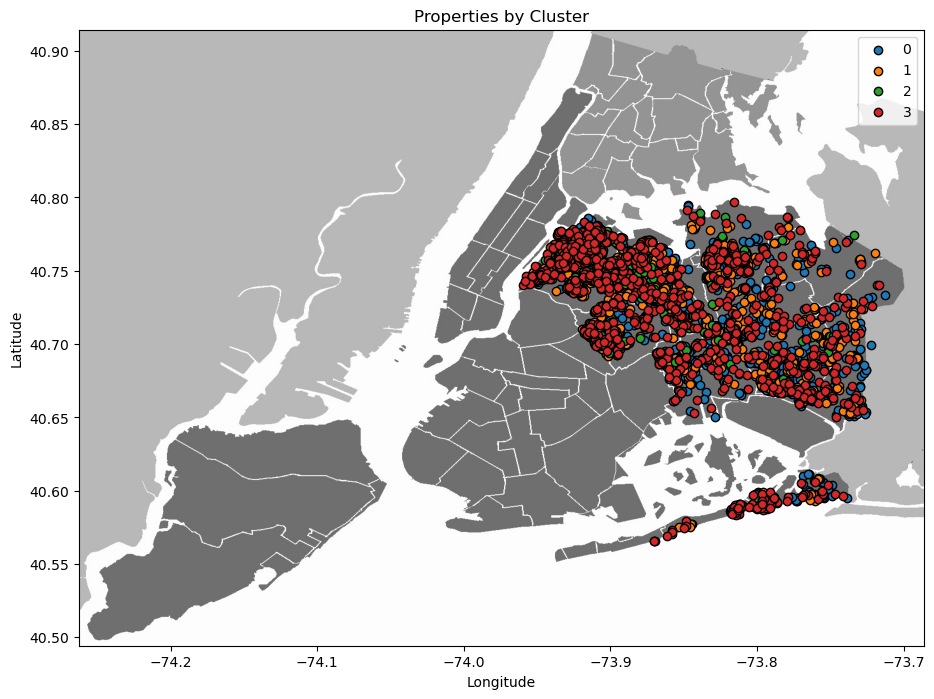

In [97]:
plt.figure(figsize=(12,8))
plt.style.use('fast')

# Set the boundary of the map using longitude and latitude obtained from Google Maps
coordinates = (-74.2623, -73.6862, 40.4943, 40.9144)

map = mpimg.imread("New_York_City.jpg")
plt.imshow(map,extent=coordinates)

# Group by cluster labels instead of neighbourhood group
clusters = kmeans_run.groupby('cluster')

# Loop through each cluster and plot the listings in it
for name, group in clusters:
    plt.scatter(group['longitude'], group['latitude'], label=name, edgecolors='black')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Properties by Cluster')
plt.legend()

### Figure 8. Mean latitude and longitude per cluster

In [98]:
latitude_mean = kmeans_run.groupby('cluster')['latitude'].mean()
print(latitude_mean)

longitude_mean = kmeans_run.groupby('cluster')['longitude'].mean()
print(longitude_mean)

log_rev_opp__mean = kmeans_run.groupby('cluster')['log_revenue_opportunity'].mean()
print(log_rev_opp__mean)

cluster
0    40.726851
1    40.731542
2    40.739832
3    40.725164
Name: latitude, dtype: float64
cluster
0   -73.862784
1   -73.867199
2   -73.886560
3   -73.863788
Name: longitude, dtype: float64
cluster
0    0.171818
1   -0.843104
2   -2.629761
3    1.033938
Name: log_revenue_opportunity, dtype: float64


In [99]:
# Convert series to df
kmeans_queens = log_rev_opp__mean.reset_index()

# Merge the mean latitude and longitude with the original DataFrame
kmeans_queens = kmeans_queens.merge(latitude_mean, on='cluster', how='left')
kmeans_queens = kmeans_queens.merge(longitude_mean, on='cluster', how='left')

# Rename columns
kmeans_queens.columns = ['cluster', 'Mean Log Rev Opp', 'Mean Latitude', 'Mean Longitude']
kmeans_queens = kmeans_queens.sort_values(by=['Mean Log Rev Opp'])

kmeans_queens

,cluster,Mean Log Rev Opp,Mean Latitude,Mean Longitude
2,2,-2.629761,40.739832,-73.886560
1,1,-0.843104,40.731542,-73.867199
0,0,0.171818,40.726851,-73.862784
3,3,1.033938,40.725164,-73.863788


In [100]:
styled_df = kmeans_queens.style.background_gradient(
    cmap='Blues', subset=['Mean Log Rev Opp', 'Mean Latitude', 'Mean Longitude']
).hide_index().set_table_styles(
    [
        {
            'selector': 'th',
            'props': [
                ('padding', '1px'),
                ('text-align', 'left')
            ]
        },
        {
            'selector': 'td',
            'props': [
                ('padding', '1px'),
                ('text-align', 'center')
            ]
        }
    ]
).set_properties(**{'width': '70px'})

styled_df

cluster,Mean Log Rev Opp,Mean Latitude,Mean Longitude
2,-2.629761,40.739832,-73.886560
1,-0.843104,40.731542,-73.867199
0,0.171818,40.726851,-73.862784
3,1.033938,40.725164,-73.863788
